# Adam Gromada
Projekt zaliczeniowy - Data Science ING

Prognozowanie cen nieruchomosci mieszkalnych

    Import bibliotek

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import matplotlib.pyplot as plt

    Import danych

In [2]:
df = pd.read_csv('ames2000_NAfix.csv')

In [3]:
df.head(10)

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,...,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,None,None,0,9,2006,New,Partial,342643
5,20,RL,50,4280,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2009,WD,Normal,88750
6,20,RL,155,20064,Pave,None,IR1,Low,AllPub,Inside,...,0,None,None,None,0,5,2007,WD,Normal,279000
7,20,RM,60,7200,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2006,COD,Normal,105000
8,20,RL,70,9100,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2006,WD,Normal,235000
9,70,C (all),None,6449,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,3,2010,WD,Abnorml,93369


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
MS.SubClass        2000 non-null int64
MS.Zoning          2000 non-null object
Lot.Frontage       2000 non-null object
Lot.Area           2000 non-null int64
Street             2000 non-null object
Alley              2000 non-null object
Lot.Shape          2000 non-null object
Land.Contour       2000 non-null object
Utilities          2000 non-null object
Lot.Config         2000 non-null object
Land.Slope         2000 non-null object
Neighborhood       2000 non-null object
Condition.1        2000 non-null object
Condition.2        2000 non-null object
Bldg.Type          2000 non-null object
House.Style        2000 non-null object
Overall.Qual       2000 non-null int64
Overall.Cond       2000 non-null int64
Year.Built         2000 non-null int64
Year.Remod.Add     2000 non-null int64
Roof.Style         2000 non-null object
Roof.Matl          2000 non-null object
Exterior.1st       

    Określenie brakujących wartości i ich uzupełnienie

In [5]:
df.loc[:, (df.isnull().sum()>0)].isnull().sum()

Mas.Vnr.Type      16
Bsmt.Qual          1
Bsmt.Cond          1
Bsmt.Exposure      3
BsmtFin.Type.1     1
BsmtFin.Type.2     2
Garage.Finish      2
Garage.Qual        1
Garage.Cond        1
dtype: int64

lista kolumn z brakującymi wartościami

In [6]:
kolumny_puste = list(df.loc[:, (df.isnull().sum()>0)].isnull().sum().index)
kolumny_puste

['Mas.Vnr.Type',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'Bsmt.Exposure',
 'BsmtFin.Type.1',
 'BsmtFin.Type.2',
 'Garage.Finish',
 'Garage.Qual',
 'Garage.Cond']

brakujących wartości jest mało, dlatego zastąpię je wartościami najczęstszymi

In [7]:
for kolumna in kolumny_puste:
    df[kolumna] = df[kolumna].fillna(df[kolumna].value_counts().index[0])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
MS.SubClass        2000 non-null int64
MS.Zoning          2000 non-null object
Lot.Frontage       2000 non-null object
Lot.Area           2000 non-null int64
Street             2000 non-null object
Alley              2000 non-null object
Lot.Shape          2000 non-null object
Land.Contour       2000 non-null object
Utilities          2000 non-null object
Lot.Config         2000 non-null object
Land.Slope         2000 non-null object
Neighborhood       2000 non-null object
Condition.1        2000 non-null object
Condition.2        2000 non-null object
Bldg.Type          2000 non-null object
House.Style        2000 non-null object
Overall.Qual       2000 non-null int64
Overall.Cond       2000 non-null int64
Year.Built         2000 non-null int64
Year.Remod.Add     2000 non-null int64
Roof.Style         2000 non-null object
Roof.Matl          2000 non-null object
Exterior.1st       

    Przygotowanie danych do regresji poprzez kodowanie zmiennych tekstowych do kategorii liczbowych

In [9]:
kolumny_tekst = list(df.select_dtypes(include='object').columns)
print(kolumny_tekst)
print(len(kolumny_tekst))

['MS.Zoning', 'Lot.Frontage', 'Street', 'Alley', 'Lot.Shape', 'Land.Contour', 'Utilities', 'Lot.Config', 'Land.Slope', 'Neighborhood', 'Condition.1', 'Condition.2', 'Bldg.Type', 'House.Style', 'Roof.Style', 'Roof.Matl', 'Exterior.1st', 'Exterior.2nd', 'Mas.Vnr.Type', 'Mas.Vnr.Area', 'Exter.Qual', 'Exter.Cond', 'Foundation', 'Bsmt.Qual', 'Bsmt.Cond', 'Bsmt.Exposure', 'BsmtFin.Type.1', 'BsmtFin.SF.1', 'BsmtFin.Type.2', 'BsmtFin.SF.2', 'Bsmt.Unf.SF', 'Total.Bsmt.SF', 'Heating', 'Heating.QC', 'Central.Air', 'Electrical', 'Bsmt.Full.Bath', 'Bsmt.Half.Bath', 'Kitchen.Qual', 'Functional', 'Fireplace.Qu', 'Garage.Type', 'Garage.Yr.Blt', 'Garage.Finish', 'Garage.Cars', 'Garage.Area', 'Garage.Qual', 'Garage.Cond', 'Paved.Drive', 'Pool.QC', 'Fence', 'Misc.Feature', 'Sale.Type', 'Sale.Condition']
54


kodowanie zmiennych tekstowych do liczbowych w celu regresji

In [10]:
for kolumna_zmieniana in kolumny_tekst:
    kolumna_zamieniona = pd.get_dummies(df[kolumna_zmieniana], prefix=kolumna_zmieniana)
    df = df.drop(kolumna_zmieniana, axis=1)
    df = df.join(kolumna_zamieniona)

In [11]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4255 columns):
MS.SubClass               int64
Lot.Area                  int64
Overall.Qual              int64
Overall.Cond              int64
Year.Built                int64
Year.Remod.Add            int64
X1st.Flr.SF               int64
X2nd.Flr.SF               int64
Low.Qual.Fin.SF           int64
Gr.Liv.Area               int64
Full.Bath                 int64
Half.Bath                 int64
Bedroom.AbvGr             int64
Kitchen.AbvGr             int64
TotRms.AbvGrd             int64
Fireplaces                int64
Wood.Deck.SF              int64
Open.Porch.SF             int64
Enclosed.Porch            int64
X3Ssn.Porch               int64
Screen.Porch              int64
Pool.Area                 int64
Misc.Val                  int64
Mo.Sold                   int64
Yr.Sold                   int64
SalePrice                 int64
MS.Zoning_A (agr)         uint8
MS.Zoning_C (all)         u

    Modelowanie

podział na zbiory testowe i treningowe

In [12]:
X = df.drop(["SalePrice"], axis=1)
y = df["SalePrice"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

regresja liniowa

In [13]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
lin_y_pred = linear_regressor.predict(X_test)
mae_linear = metrics.mean_absolute_error(y_test, lin_y_pred)
rmse_linear = np.sqrt(metrics.mean_squared_error(y_test, lin_y_pred))
r2_score_linear = metrics.r2_score(y_test, lin_y_pred)
print(f"Regresja liniowa:\n MAE={mae_linear}\n RMSE={rmse_linear}\n r2 score={r2_score_linear}")

Regresja liniowa:
 MAE=19214.0277894616
 RMSE=26850.007114952456
 r2 score=0.8921305960137277


regresja ridge

In [14]:
ridge = Ridge()
parameters = {'alpha': [0.01, 0.1, 1, 5, 10, 20, 40, 80, 100, 250, 500, 1000]}
ridge_regressor = GridSearchCV(ridge, parameters, cv=5)
ridge_regressor.fit(X_train, y_train)
print(f"Najlepszy wybrany parametr {ridge_regressor.best_params_}")
print(f"Score dla parametru alpha {ridge_regressor.best_score_}")
ridge_regressor = Ridge(alpha=ridge_regressor.best_params_['alpha'])
ridge_regressor.fit(X_train, y_train)
ridge_y_pred = ridge_regressor.predict(X_test)
mae_ridge = metrics.mean_absolute_error(y_test, ridge_y_pred)
rmse_ridge = np.sqrt(metrics.mean_squared_error(y_test, ridge_y_pred))
r2_score_ridge = metrics.r2_score(y_test, ridge_y_pred)
print(f"Regresja ridge:\n MAE={mae_ridge}\n RMSE={rmse_ridge}\n r2 score={r2_score_ridge}")

Najlepszy wybrany parametr {'alpha': 20}
Score dla parametru alpha 0.8647659146927944
Regresja ridge:
 MAE=15751.42264645177
 RMSE=23197.25179459543
 r2 score=0.9194839349590167


regresja lasso

In [15]:
lasso = Lasso()
parameters = {'alpha': [20, 60, 100, 250, 500, 750, 1000]}
lasso_regressor = GridSearchCV(lasso, parameters, cv=5)
lasso_regressor.fit(X_train,y_train)
lasso_regressor.best_params_
print(f"Najlepszy wybrany parametr {lasso_regressor.best_params_}")
print(f"Score dla parametru alpha {lasso_regressor.best_score_}")
lasso_regressor = Lasso(alpha=lasso_regressor.best_params_['alpha'])
lasso_regressor.fit(X_train, y_train)
lasso_y_pred = lasso_regressor.predict(X_test)
mae_lasso = metrics.mean_absolute_error(y_test, lasso_y_pred)
rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, lasso_y_pred))
r2_score_lasso = metrics.r2_score(y_test, lasso_y_pred)
print(f"Regresja lasso.\n MAE={mae_lasso}\n RMSE={rmse_lasso}\n r2 score={r2_score_lasso}")

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Najlepszy wybrany parametr {'alpha': 250}
Score dla parametru alpha 0.8671228196747741
Regresja lasso.
 MAE=15730.303987162735
 RMSE=22831.366582673145
 r2 score=0.9220038289144619


porównanie wynikow w formie tabeli

In [16]:
dane = [['Liniowa',mae_linear, rmse_linear, r2_score_linear],['Ridge',mae_ridge, rmse_ridge, r2_score_ridge],['Lasso',mae_lasso, rmse_lasso, r2_score_lasso]]
tabelka = pd.DataFrame(dane,columns=['Model regresji','MAE', 'RMSE', 'R2 Score'])
tabelka.set_index('Model regresji', inplace=True)
tabelka

,MAE,RMSE,R2 Score
Model regresji,,,
Liniowa,19214.027789,26850.007115,0.892131
Ridge,15751.422646,23197.251795,0.919484
Lasso,15730.303987,22831.366583,0.922004


porównanie wyników w formie wykresów

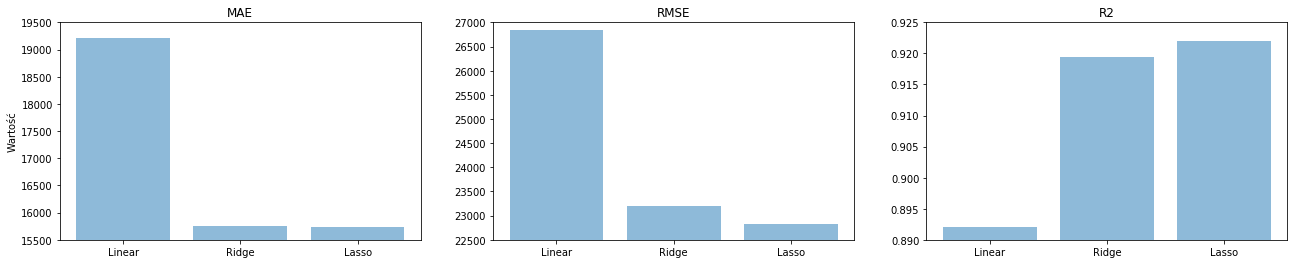

In [17]:
objects = ('Linear', 'Ridge', 'Lasso')
y_pos = np.arange(len(objects))
MAE = [mae_linear, mae_ridge, mae_lasso]
RMSE = [rmse_linear, rmse_ridge, rmse_lasso]
R2= [r2_score_linear, r2_score_ridge, r2_score_lasso]

f, axs = plt.subplots(1,3,figsize=(22,4))

plt.subplot(1,3,1)
plt.bar(y_pos, MAE, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Wartość')
plt.title('MAE')
plt.ylim(15500, 19500)

plt.subplot(1,3,2)
plt.bar(y_pos, RMSE, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('RMSE')
plt.ylim(22500,27000)

plt.subplot(1,3,3)
plt.bar(y_pos, R2, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('R2')
plt.ylim(0.89,0.925)

plt.show()

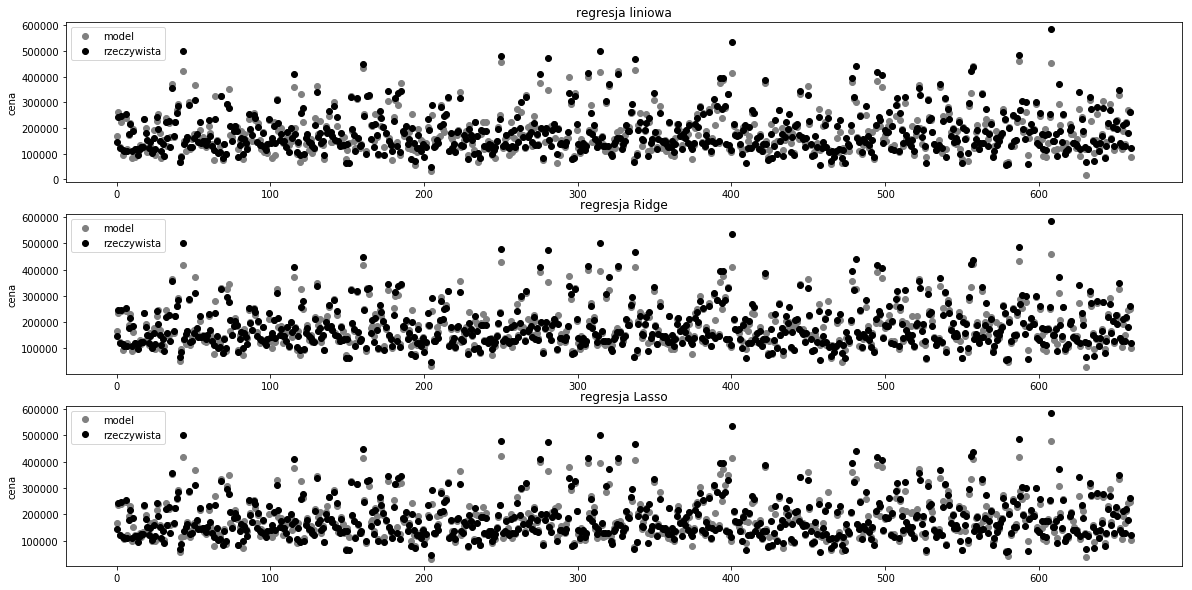

In [18]:
f, axs = plt.subplots(3,1,figsize=(20,10))

plt.subplot(3,1,1)
plot_x = np.linspace(0, lin_y_pred.size, lin_y_pred.size)
plt.plot(plot_x, lin_y_pred, 'o', color='grey', label='model')
plt.plot(plot_x, y_test, 'o', color='black', label='rzeczywista')
plt.ylabel('cena')
plt.title('regresja liniowa')
plt.legend(loc='upper left')

plt.subplot(3,1,2)
plot_x = np.linspace(0, lin_y_pred.size, lin_y_pred.size)
plt.plot(plot_x, ridge_y_pred, 'o', color='grey', label='model')
plt.plot(plot_x, y_test, 'o', color='black', label='rzeczywista')
plt.ylabel('cena')
plt.title('regresja Ridge')
plt.legend(loc='upper left')

plt.subplot(3,1,3)
plot_x = np.linspace(0, lin_y_pred.size, lin_y_pred.size)
plt.plot(plot_x, lasso_y_pred, 'o', color='grey', label='model')
plt.plot(plot_x, y_test, 'o', color='black',label='rzeczywista')
plt.ylabel('cena')
plt.title('regresja Lasso')
plt.legend(loc='upper left')

plt.show()

    Konkluzje

Najlepszym modelem jest __Lasso__, który najlepiej przewiduje cenę nieruchomości a następnie __Ridge__. Model __regresji liniowej__ jest trochę gorzej przewiduje ceny nieruchomoćci, tym niemniej R2 Score (siła korelacji pomiędzy modelem a rzeczywistymi danymi) dla wszystkich modeli przekracza 0,89 co jest wartością akceptowalną.